# README - Energy Time Series Forecasting Notebook

## Structure du notebook

1. **Introduction**  

2. **Chargement et préparation des données**  
    - Importation des bibliothèques nécessaires.
    - Chargement des données et conversion des dates.
    - Création de la variable cible (`Consommation`) et suppression des colonnes inutiles.

3. **Feature Engineering**  
    - Extraction des composantes temporelles (heure, mois, jour de la semaine, etc.).
    - Encodage cyclique des variables temporelles.

4. **Prétraitement**  
    - Visualisation de la distribution des variables.
    - Normalisation des variables cibles avec `MinMaxScaler`.

5. **Construction des séquences**  
    - Création de fenêtres temporelles pour l'entraînement du modèle (48h d'historique pour prédire la prochaine heure).

6. **Séparation des jeux de données**  
    - Split en ensembles d'entraînement, validation et test.

7. **Modélisation LSTM**  
    - Définition et entraînement d'un modèle LSTM séquentiel pour la prévision univariée.
    - Sauvegarde et chargement du modèle.

8. **Évaluation**  
    - Prédiction autoregressive sur 24h.
    - Dénormalisation et calcul des métriques (MAE, RMSE, MAPE).
    - Visualisation des résultats.

9. **Analyse de la performance selon l'horizon de prédiction**  
    - Évaluation de la dégradation des performances du modèle en fonction de l'horizon de prévision (jusqu'à 2000h).
    - Sauvegarde progressive des résultats et gestion de la mémoire.

## Utilisation

- **Données** : Placez le fichier `business_group_data.csv` dans le même dossier que le notebook.
- **Entraînement** : Exécutez les cellules dans l'ordre pour préparer les données, entraîner le modèle et générer les prévisions.
- **Évaluation multi-horizon** : La dernière partie du notebook permet d'analyser la robustesse du modèle sur différents horizons de prévision.

## Dépendances

- Python 3.x
- pandas, numpy, matplotlib, seaborn, scikit-learn
- torch, tensorflow (pour les modèles LSTM)
- pickle, json, gc, os

## Remarques

- Le notebook gère la sauvegarde et la reprise automatique lors de l'évaluation multi-horizon pour éviter toute perte de calcul.
- Les résultats intermédiaires sont stockés dans des fichiers CSV et pickle pour faciliter la reprise et l'analyse.

---

# Energy Time Series Forecasting

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Chargement des données 

In [5]:
df_business_consumption=pd.read_csv('business_group_data.csv')  # Load your dataset

In [6]:
df_business_consumption['Date'] = pd.to_datetime(
    df_business_consumption['Date'])    # Convert 'Date' column to datetime

In [7]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]  # Calcul de la consommation moyenne par point de mesure 

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)  # Drop the original columns


## Feature engineering

In [8]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour   #extract hour from Date between 0 and 23
df_business_consumption['month'] = df_business_consumption['Date'].dt.month   # extract month from Date between 1 and 12
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # extract weekday 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear # extract day of year from Date between 1 and 365

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


In [9]:
df_business_consumption.drop(columns=["wind_speed", "surface_pressure"], inplace=True) # Drop the columns that are not needed for the model based on the previous analysis

##  Prétraitement des données

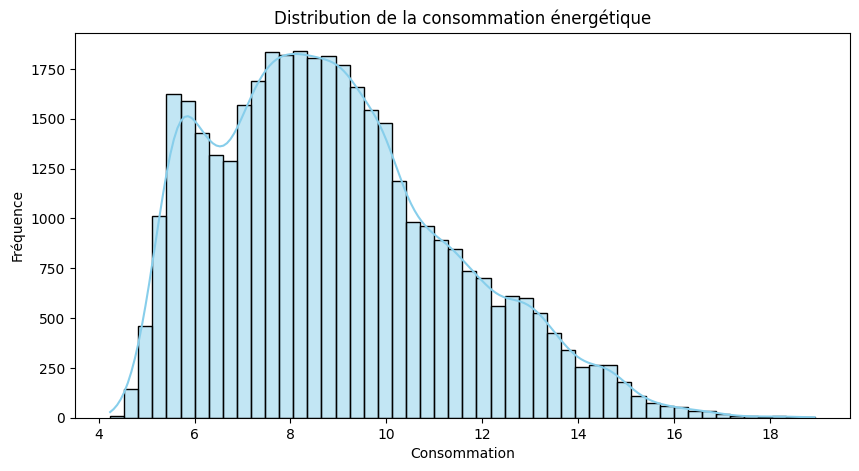

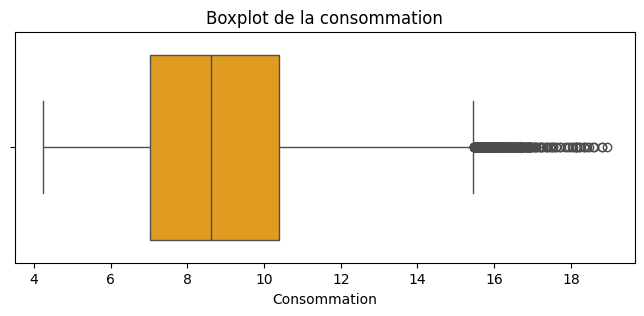

In [10]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


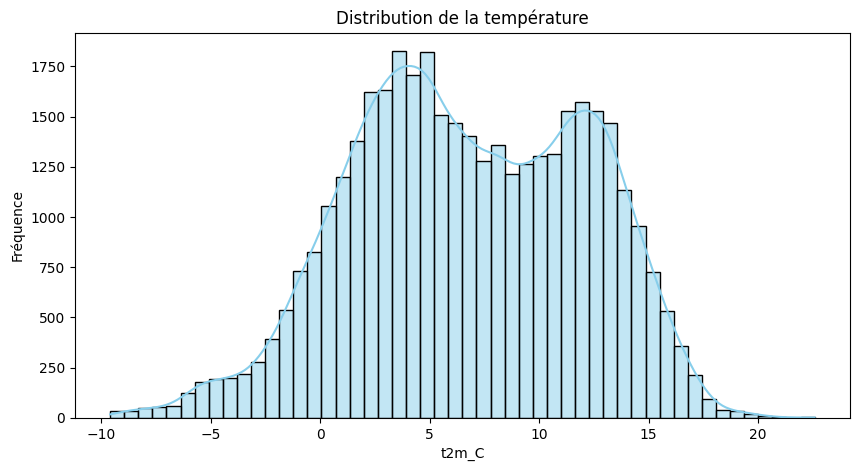

In [11]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques .

In [12]:
from sklearn.preprocessing import MinMaxScaler  # MinMaxScaler is more suitable for asymmetric and bounded data.
df_normalise=df_business_consumption.copy()     # Create a copy of the DataFrame to avoid modifying the original data
# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]  # List of columns to normalize
scalers_minmax = {}     # Dictionary to store the scalers for each column
for col in colonnes_a_normaliser:     # Iterate over each column to normalize
    scaler = MinMaxScaler()    # Create a MinMaxScaler instance
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])   # Fit and transform the column using the scaler
    scalers_minmax[col] = scaler    # Store the scaler in the dictionary for later use


In [13]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour cyclically between 0 and 23
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour cyclically between 0 and 23

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)   # Encode month cyclically between 1 and 12
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)  # Encode month cyclically between 1 and 12

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)     # Encode weekday cyclically between 0 and 6
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)    # Encode weekday cyclically between 0 and 6

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)    # Encode day of year cyclically between 1 and 365
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)    # Encode day of year cyclically between 1 and 365

In [14]:
df_normalise

,Date,t2m_C,Consommation,hour,month,weekday,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,0.350590,0.261538,0,1,4,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,0.339167,0.257389,1,1,4,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,0.329652,0.264986,2,1,4,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,0.322284,0.266281,3,1,4,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,0.318771,0.282455,4,1,4,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.508829,0.560058,9,5,3,142,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.506474,0.550630,10,5,3,142,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.517676,0.543712,11,5,3,142,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.524023,0.522251,12,5,3,142,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [15]:
df_normalise.index=df_normalise['Date']   # Set the index to the 'Date' column for time series analysis

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True) # Drop the original date and time columns as they are no longer needed

df_normalise.head()

,t2m_C,Consommation,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,
2021-01-01 00:00:00,0.350590,0.261538,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.339167,0.257389,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.329652,0.264986,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.322284,0.266281,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.318771,0.282455,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


In [16]:
col = 'Consommation'
# Réorganiser les colonnes
df_normalise = df_normalise[[col] + [c for c in df_normalise.columns if c != col]]    # Reorder columns to have 'Consommation' first

In [17]:
df_normalise.head()

,Consommation,t2m_C,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,
2021-01-01 00:00:00,0.261538,0.350590,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.257389,0.339167,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.264986,0.329652,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.266281,0.322284,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.282455,0.318771,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


---

## prediction uni_target

Construction des séquences
Créer des fenêtres de 48 heures (séquences) pour prédire les 24 heures suivantes.

pour entraîner un modèle qui, à partir de 48 heures d’historique, apprend à prédire les 24 prochaines heures une par une (autoregressive).

In [18]:
sequence_length = 48
target_col = "Consommation"
def create_sequences(data, target_col, sequence_length):
    """Create sequences for TRUE autoregressive LSTM"""
    X, y = [], []
    
    # On entraîne SEULEMENT sur la prédiction t → t+1
    for i in range(len(data) - sequence_length - 1):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_col])  # Seulement +1h
    
    return np.array(X), np.array(y)

In [19]:
# Créer les séquences à partir de vos données
X, y = create_sequences(df_normalise, target_col, sequence_length)

Séparation et entraînement

In [20]:
n = len(X)
train_end = int(0.8 * n) # 80% pour l'entraînement
val_end = int(0.9 * n)   # 10% pour la validation, 10% pour le test

X_train = X[:train_end]
X_val   = X[train_end:val_end]
X_test  = X[val_end:]
y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:]

In [21]:
X_train.shape

(30730, 48, 10)

In [22]:
y_train.shape

(30730,)

In [23]:
y_test.shape

(3842,)

In [24]:

X_test_indices = [i for i in range(len(df_normalise) - sequence_length -1)][-len(X_test):]   # Get the indices of the test set sequences for later use after predictions

Modèle LSTM

un modèle séquentiel --> chaque couche est empilée l’une après l’autre.

64 nombre de cellules (ou neurones) dans la LSTM



La MAPE mesure l'erreur relative moyenne entre les valeurs réelles et prédites, exprimée en pourcentage.
$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$



In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
 
model = Sequential([
    LSTM(64,  return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])),  # 1re couche LSTM
    LSTM(32, dropout=0.1, recurrent_dropout=0.1,  return_sequences=False),  # 2e couche LSTM
    
    Dense(1, activation='linear')  
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[MeanAbsolutePercentageError()]) # Compile the model with Adam optimizer and MSE loss function


model.summary()


c:\Users\emac\OneDrive - IMT Mines Albi\Projet stage\Eneenergy-forecasting-1\project_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, y_train, epochs=60, batch_size=30,  validation_data=(X_val, y_val),
    verbose=1)


Epoch 1/60
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.0248 - mean_absolute_percentage_error: 45.8908 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 25084.2266
Epoch 2/60
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - loss: 0.0069 - mean_absolute_percentage_error: 26.8603 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 22139.7734
Epoch 3/60
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - loss: 0.0054 - mean_absolute_percentage_error: 23.1628 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 17807.3438
Epoch 4/60
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - loss: 0.0047 - mean_absolute_percentage_error: 21.1803 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 18057.1816
Epoch 5/60
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - loss: 0.0042 - mean_absolute_percentage_error: 19.7599 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 20356.0391
Epoch 6/60
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - loss: 0.0037 - mean_absolute_percenta

In [27]:
model.save("modele_autoregressif.keras")  # extension .keras ou .h5


In [28]:
from tensorflow.keras.models import load_model

model = load_model("modele_autoregressif.keras")


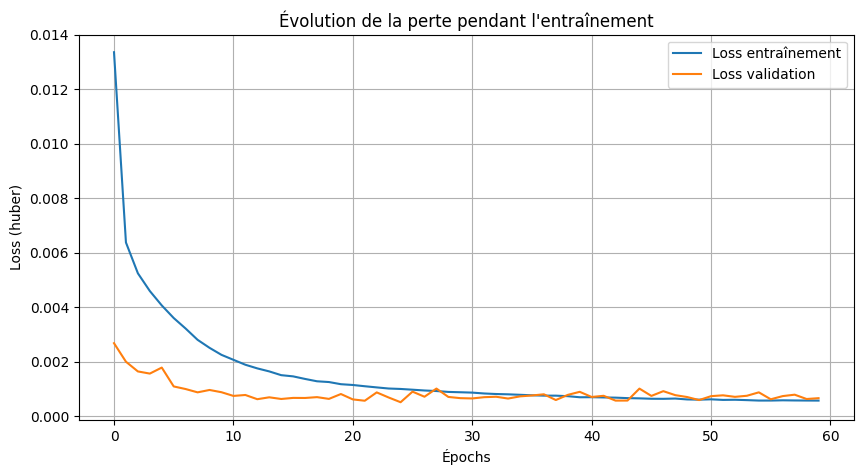

In [29]:

# Affichage de la loss d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Épochs')
plt.ylabel('Loss (huber)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
def predict_autoregressive(model, initial_sequence, forecast_horizon, target_col_index):
    """
    Fait des prédictions autoregressives sur un horizon donné.

    Arguments :
    - model : le modèle entraîné
    - initial_sequence : np.array de forme (sequence_length, n_features)
    - forecast_horizon : nombre total de pas à prédire
    - target_col_index : index de la colonne cible (consommation)

    Retour :
    - np.array de forme (forecast_horizon,) contenant les prédictions
    """
    current_seq = initial_sequence.copy()
    preds = []

    for _ in range(forecast_horizon):
        # Prédire la prochaine valeur (modèle attend un batch)
        model_input = current_seq.reshape(1, current_seq.shape[0], current_seq.shape[1])
        next_pred = model.predict(model_input, verbose=0)[0, 0]  # On extrait le scalaire
        preds.append(next_pred)

        # Mettre à jour la séquence : enlever le premier pas, ajouter le nouveau
        new_row = current_seq[-1].copy()  # On copie la dernière ligne (dernière heure)
        new_row[target_col_index] = next_pred  # Injection : on met à jour la consommation prédite

        # Fenêtre glissante : on décale
        current_seq = np.vstack([current_seq[1:], new_row.reshape(1, -1)])

    return np.array(preds)


In [31]:
forecast_horizon = 24
sequence_length = 48
target_col = "Consommation"
target_col_index = df_normalise.columns.get_loc(target_col)

all_preds = []
all_targets = []

i=0
initial_seq = X_test[i]  # shape: (48, n_features)
    
start_idx = i
end_idx = start_idx + forecast_horizon

true_vals = y_test[start_idx:end_idx]  # séquence vraie (24,)

preds = predict_autoregressive(
    model=model,
    initial_sequence=initial_seq,
    forecast_horizon=forecast_horizon,
    target_col_index=target_col_index
    )

all_preds.append(preds)
all_targets.append(true_vals)


In [32]:
# Convertir en arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Dénormalisation
all_preds_inv = scalers_minmax['Consommation'].inverse_transform(all_preds.reshape(-1, 1)).reshape(all_preds.shape)
all_targets_inv = scalers_minmax['Consommation'].inverse_transform(all_targets.reshape(-1, 1)).reshape(all_targets.shape)


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_flat = all_preds_inv.flatten()
y_true_flat = all_targets_inv.flatten()

mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


MAE : 0.91
RMSE : 1.03
MAPE : 9.48%


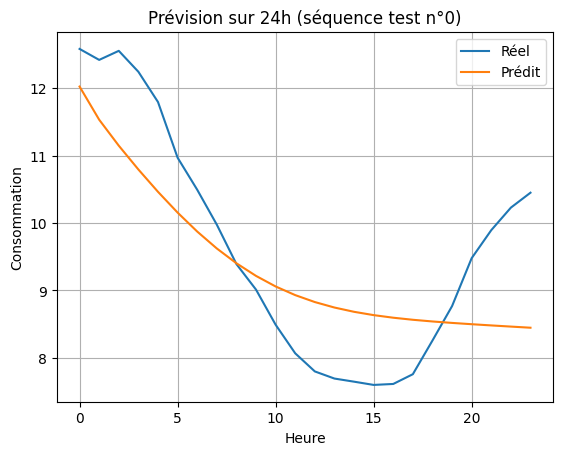

In [34]:
import matplotlib.pyplot as plt

i = 0
plt.plot(all_targets_inv[i], label="Réel")
plt.plot(all_preds_inv[i], label="Prédit")
plt.title("Prévision sur 24h (séquence test n°0)")
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.show()


---

## Variation d'horizon de temps 

 répondre à une question :

 Comment la performance de mon modèle LSTM se dégrade-t-elle lorsque j’essaie de prédire de plus en plus loin dans le futur (augmentation de l’horizon de prédiction) ?

In [ ]:
import numpy as np
import pandas as pd
import os   # Pour la gestion des fichiers
import gc  # Nettoyage mémoire
import pickle  # Pour la sauvegarde des états
import json  # Pour la sauvegarde des états
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================================================================
def predict_autoregressive_up_to(model, initial_sequence, max_horizon):  #function to generate autoregressive predictions up to max_horizon
    """Génère des prédictions autorégressive jusqu'à max_horizon"""
    current_input = initial_sequence.copy()   # Copy the initial sequence to avoid modifying the original
    preds = []  # Initialize an empty list to store predictions
    
    for step in range(max_horizon):
        pred = model.predict(current_input[np.newaxis, :, :], verbose=0)    # Predict the next value
        next_val = pred[0][0]
        preds.append(next_val)  # Store the predicted value
        
        # Mise à jour pour le prochain pas
        next_input = np.zeros_like(current_input)
        next_input[:-1] = current_input[1:]
        next_input[-1, 0] = next_val
        current_input = next_input
    
    return np.array(preds)

def save_progress_state(predictions, true_values, current_sample, max_samples,   #function to save the complete progress state
                       predictions_cache, progress_file):
    """Sauvegarde l'état complet du progrès"""
    try:
        # Sauvegarder les données
        cache_data = {
            'predictions': predictions,
            'true_values': true_values,
            'samples_done': len(predictions),
            'current_sample': current_sample,
            'max_samples': max_samples,
            'timestamp': pd.Timestamp.now().isoformat()
        }
        
        with open(predictions_cache, 'wb') as f: # Save the predictions and true values
            pickle.dump(cache_data, f)
        
        # Sauvegarder les métadonnées (plus léger à lire)
        progress_data = {
            'samples_done': len(predictions),
            'current_sample': current_sample,
            'max_samples': max_samples,
            'last_update': pd.Timestamp.now().isoformat(),
            'cache_file_exists': True
        }
        
        with open(progress_file, 'w') as f:  # Save the progress state in JSON format
            json.dump(progress_data, f, indent=2)
            
        return True
    except Exception as e:
        print(f" Erreur sauvegarde: {e}")
        return False

def load_progress_state(predictions_cache, progress_file):  #function to load the progress state with verification
    """Charge l'état du progrès avec vérification"""
    try:
        # Vérifier les métadonnées
        if os.path.exists(progress_file):  # Check if the progress file exists
            with open(progress_file, 'r') as f:
                progress_data = json.load(f)
            print(f" État sauvegardé trouvé: {progress_data['samples_done']} échantillons")
        
        # Charger les données principales
        if os.path.exists(predictions_cache):
            with open(predictions_cache, 'rb') as f:  # Load the predictions and true values
                cached_data = pickle.load(f)
            
            predictions = cached_data['predictions']  # Get predictions from cache
            true_values = cached_data['true_values']  # Get true values from cache
            start_sample = len(predictions)  # Get the number of samples already processed
            
            print(f" Cache valide: {start_sample} prédictions chargées")
            return predictions, true_values, start_sample
        else:
            return [], [], 0
            
    except Exception as e:
        print(f" Erreur chargement cache: {e}")
        print(" Redémarrage complet...")
        return [], [], 0

# ============================================================================
# PARAMÈTRES ET INITIALISATION
# ============================================================================

# Paramètres
max_total_horizon = 2000
results_file = 'results_horizon_autoregression.csv'
predictions_cache = 'predictions_cache.pkl'
progress_file = 'progress_state.json'
SAVE_EVERY = 25  # Sauvegarde plus fréquente pour plus de sécurité

print("=== ÉVALUATION MULTI-HORIZON (ULTRA-ROBUSTE) ===")
print(f"Modèle: {type(model).__name__}")
print(f"Données test: {X_test.shape}")
print(f"Sauvegarde toutes les {SAVE_EVERY} prédictions")
print(f"Cache: {predictions_cache}")
print(f"Progrès: {progress_file}")

# Charger résultats existants des métriques
if os.path.exists(results_file):  # Check if results file exists
    results_df = pd.read_csv(results_file)
    processed_horizons = set(results_df['horizon'].values)  # Get processed horizons from results
    print(f"Métriques - Horizons déjà traités: {len(processed_horizons)}")
else:
    results_df = pd.DataFrame(columns=["horizon", "MAE", "RMSE", "MAPE", "samples"])
    processed_horizons = set()
    print("Métriques - Nouveau fichier")

# Calcul des échantillons utilisables
max_samples = min(len(X_test), len(y_test) - max_total_horizon)
print(f"Échantillons totaux à traiter: {max_samples}")

# ============================================================================
#  GÉNÉRATION ROBUSTE DES PRÉDICTIONS
# ============================================================================

print(f"\n Génération/chargement des prédictions...")

# Charger l'état précédent
all_predictions, all_true_values, start_sample = load_progress_state(
    predictions_cache, progress_file
)

if start_sample > 0:
    print(f" Reprise détectée!")
    print(f"    {start_sample} échantillons déjà traités")
    print(f"    Reprise à l'échantillon {start_sample + 1}/{max_samples}")
    
    # Vérification de cohérence
    if start_sample >= max_samples:
        print(" Toutes les prédictions sont déjà terminées!")
        all_predictions = np.array(all_predictions)
        all_true_values = np.array(all_true_values)
    else:
        print(f"    Reste {max_samples - start_sample} échantillons à traiter")
else:
    print(" Nouveau calcul complet")

# Continuer les prédictions là où on s'était arrêté
if start_sample < max_samples:
    print(f"\n Traitement des échantillons {start_sample + 1} à {max_samples}...")
    
    for i in range(start_sample, max_samples):
        try:
            # Affichage du progrès
            if i == start_sample or (i + 1) % 25 == 0:
                progression = ((i + 1) / max_samples) * 100
                print(f"    Échantillon {i+1}/{max_samples} ({progression:.1f}%)")
            
            # Générer prédiction pour cet échantillon
            initial_seq = X_test[i]
            preds = predict_autoregressive_up_to(model, initial_seq, max_total_horizon)
            true_vals = y_test[i:i+max_total_horizon]
            
            # Ajouter aux listes
            all_predictions.append(preds)
            all_true_values.append(true_vals)
            
            # SAUVEGARDE PROGRESSIVE ULTRA-SÉCURISÉE
            if (i + 1) % SAVE_EVERY == 0 or (i + 1) == max_samples:
                success = save_progress_state(
                    all_predictions, all_true_values, i + 1, max_samples,
                    predictions_cache, progress_file
                )
                
                if success:
                    print(f"    Sauvegarde OK: {i+1} échantillons")
                else:
                    print(f"    Échec sauvegarde à l'échantillon {i+1}")
                
                # Nettoyage mémoire périodique
                if (i + 1) % (SAVE_EVERY * 4) == 0:
                    gc.collect()
                    
        except KeyboardInterrupt:
            print(f"\n INTERRUPTION DÉTECTÉE À L'ÉCHANTILLON {i+1}")
            print(" Sauvegarde d'urgence...")
            save_progress_state(
                all_predictions, all_true_values, i, max_samples,
                predictions_cache, progress_file
            )
            print(" Sauvegarde d'urgence terminée")
            print(" Relancez le script pour reprendre là où vous vous êtes arrêté")
            exit(0)
            
        except Exception as e:
            print(f" Erreur à l'échantillon {i+1}: {e}")
            print(" Sauvegarde d'urgence...")
            save_progress_state(
                all_predictions, all_true_values, i, max_samples,
                predictions_cache, progress_file
            )
            print(" Arrêt suite à erreur - relancez pour reprendre")
            raise e

# Conversion finale en numpy
all_predictions = np.array(all_predictions)  # Convertir en array numpy for efficient processing
all_true_values = np.array(all_true_values)
print(f" Prédictions terminées: {all_predictions.shape}")

# ============================================================================
#  DÉNORMALISATION
# ============================================================================

print(f"\n Dénormalisation...")
scaler = scalers_minmax['Consommation']

try:
    all_preds_inv = scaler.inverse_transform(
        all_predictions.reshape(-1, 1)  # Dénormalisation des prédictions
    ).reshape(all_predictions.shape)

    all_true_inv = scaler.inverse_transform(
        all_true_values.reshape(-1, 1)
    ).reshape(all_true_values.shape)
    
    print(" Dénormalisation terminée")
except Exception as e:
    print(f" Erreur dénormalisation: {e}")
    raise e

# ============================================================================
# CALCUL DES MÉTRIQUES PAR HORIZON
# ============================================================================

print(f"\n Calcul des métriques par horizon...")

new_results = []
horizons_to_process = [h for h in range(1, max_total_horizon + 1) 
                      if h not in processed_horizons]

print(f"Horizons à traiter: {len(horizons_to_process)}")

if len(horizons_to_process) > 0:   # If there are horizons to process
    for i, horizon in enumerate(horizons_to_process):  # Loop through each horizon to process
        try:
            if (i + 1) % 100 == 0:  # Print progress every 100 horizons
                progress_h = ((i + 1) / len(horizons_to_process)) * 100
                print(f"    Horizon {horizon}/{max_total_horizon} ({progress_h:.1f}%)")
            
            # Extraire données pour cet horizon
            y_pred_h = all_preds_inv[:, :horizon].flatten()
            y_true_h = all_true_inv[:, :horizon].flatten()
            
            # Calculer métriques
            mae = mean_absolute_error(y_true_h, y_pred_h)
            rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
            
            # MAPE robuste
            mask = y_true_h != 0
            if np.sum(mask) > 0:   # Check if there are non-zero true values
                mape = np.mean(np.abs((y_true_h[mask] - y_pred_h[mask]) / y_true_h[mask])) * 100   # Calculate MAPE only for non-zero true values
            else:
                mape = 0.0
            
            new_results.append({
                "horizon": horizon,
                "MAE": mae,
                "RMSE": rmse,
                "MAPE": mape,
                "samples": len(all_predictions)
            })
            
            # Sauvegarde intermédiaire des métriques
            if (i + 1) % 200 == 0:
                temp_df = pd.concat([results_df, pd.DataFrame(new_results)], ignore_index=True)  # Concatenate new results
                temp_df.to_csv(results_file, index=False)   # Save to CSV
                print(f"    Métriques sauvegardées (horizon {horizon})")   
                
        except Exception as e:
            print(f" Erreur calcul horizon {horizon}: {e}")
            # Sauvegarder ce qu'on a déjà calculé
            if new_results:
                temp_df = pd.concat([results_df, pd.DataFrame(new_results)], ignore_index=True)  # Concatenate new results
                temp_df.to_csv(results_file, index=False)
                print(f" Sauvegarde d'urgence: {len(new_results)} horizons")
            raise e
else:
    print(" Tous les horizons sont déjà calculés!")

# ============================================================================
#  SAUVEGARDE FINALE ET NETTOYAGE
# ============================================================================

print(f"\n Sauvegarde finale...")
if new_results:
    results_df = pd.concat([results_df, pd.DataFrame(new_results)], ignore_index=True)
    results_df.to_csv(results_file, index=False)
    print(f" {len(new_results)} nouveaux horizons sauvegardés")

print(f"\n Nettoyage...")
# Supprimer les fichiers cache une fois terminé
files_to_clean = [predictions_cache, progress_file]
for file_path in files_to_clean:
    if os.path.exists(file_path):  # Check if the file exists before trying to delete
        try:
            os.remove(file_path)
            print(f" {file_path} supprimé")
        except:
            print(f" Impossible de supprimer {file_path}")



# Nettoyage mémoire final
del all_predictions, all_true_values, all_preds_inv, all_true_inv  # Clear large arrays
gc.collect()
print(" Mémoire nettoyée")





=== ÉVALUATION MULTI-HORIZON (ULTRA-ROBUSTE) ===
Modèle: Sequential
Données test: (3842, 48, 10)
Sauvegarde toutes les 25 prédictions
Cache: predictions_cache.pkl
Progrès: progress_state.json
Métriques - Nouveau fichier
Échantillons totaux à traiter: 1842

 Génération/chargement des prédictions...
 Nouveau calcul complet

 Traitement des échantillons 1 à 1842...
    Échantillon 1/1842 (0.1%)
    Échantillon 25/1842 (1.4%)
    Sauvegarde OK: 25 échantillons
    Échantillon 50/1842 (2.7%)
    Sauvegarde OK: 50 échantillons
    Échantillon 75/1842 (4.1%)
    Sauvegarde OK: 75 échantillons
    Échantillon 100/1842 (5.4%)
    Sauvegarde OK: 100 échantillons
    Échantillon 125/1842 (6.8%)
    Sauvegarde OK: 125 échantillons
    Échantillon 150/1842 (8.1%)
    Sauvegarde OK: 150 échantillons
    Échantillon 175/1842 (9.5%)
    Sauvegarde OK: 175 échantillons
    Échantillon 200/1842 (10.9%)
    Sauvegarde OK: 200 échantillons
    Échantillon 225/1842 (12.2%)
    Sauvegarde OK: 225 échantillo